In [1]:
import sys
sys.path.append("../../")

from astronn import datasets
from astronn import models

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Create a dataset with 1Mll theoretical stars oscilations

In [2]:
star_models = datasets.starmodels()
df = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=150)

#### Print sample vectors from Dataset

In [3]:
for row in df.take(1):
    print(row)

(<tf.Tensor: id=1732, shape=(150, 406, 3), dtype=float32, numpy=
array([[[ 0.    ,  0.    ,  1.    ],
        [ 0.    ,  0.    ,  0.9897],
        [ 0.    ,  0.    ,  0.9117],
        ...,
        [ 0.    ,  0.    ,  0.1253],
        [ 0.    ,  0.    ,  0.1281],
        [ 0.    ,  0.    ,  0.2429]],

       [[ 0.    ,  0.    ,  1.    ],
        [ 0.    ,  0.    ,  0.9899],
        [ 0.    ,  0.    ,  0.9134],
        ...,
        [ 0.    ,  0.    , -0.0646],
        [ 0.    ,  0.    , -0.0465],
        [ 0.    ,  0.    ,  0.1833]],

       [[ 0.    ,  0.    ,  1.    ],
        [ 0.    ,  0.    ,  0.9895],
        [ 0.    ,  0.    ,  0.9095],
        ...,
        [ 0.    ,  0.    , -0.0459],
        [ 0.    ,  0.    , -0.0309],
        [ 0.    ,  0.    ,  0.1875]],

       ...,

       [[ 0.    ,  3.    ,  1.    ],
        [ 0.    ,  0.    ,  0.99  ],
        [ 0.    ,  0.    ,  0.9141],
        ...,
        [ 0.    ,  0.    ,  0.0809],
        [ 0.    ,  0.    ,  0.0676],
        [ 0. 

In [4]:
def normalize(x):
    """
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x))

#### Take one example

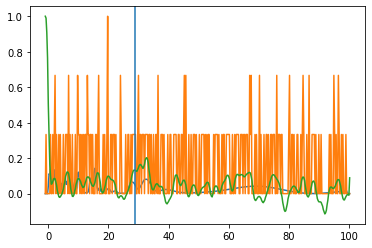

In [5]:
line = [line for line in df.take(1)]

x = np.arange(-1, 100.5, 0.25)
plt.plot(x, line[0][0][0,:,0])
plt.plot(x, normalize(line[0][0][0,:,1]))
plt.plot(x, line[0][0][0,:,2])

target = np.where(line[0][1][0].numpy().flat == 1)[0].flat[0]
plt.axvline(x=target)

#### Sampling to check non all-zeros one-hot vector target

In [6]:
aux = []
for row in df.take(50):
    for r in row[1]:
        if len(np.where(r[0])[0]) > 0:
            aux.append(np.where(r[0])[0][0])
        else:
            print(row)
            print(r[0])
            0 / 0

(array([ 385.,  735.,  768.,  930., 1080., 1247., 1120.,  517.,  331.,
         387.]),
 array([18. , 26.1, 34.2, 42.3, 50.4, 58.5, 66.6, 74.7, 82.8, 90.9, 99. ]),
 <a list of 10 Patch objects>)

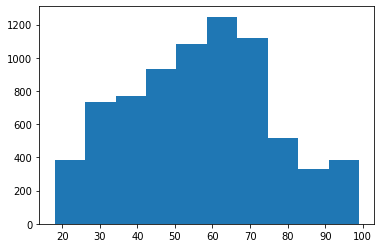

In [7]:
plt.hist(aux) # PLot histogram of targets

#### Create a Separable convolution model

In [8]:
sepconv_mod = models.separableconvnn() #init model
sepconv_mod.compile(learning_rate=0.0001) # compile model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 402, 10)           145       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 134, 10)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 134, 10)           40        
_________________________________________________________________
dropout (Dropout)            (None, 134, 10)           0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 130, 10)           460       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 43, 10)            0         
____________________________

#### Train model with dataset

In [9]:
history = sepconv_mod.model.fit(df, steps_per_epoch=100, epochs=100)

Train for 100 steps
Epoch 1/50
100/100 [==============================] - 8s 82ms/step - loss: 5.5533 - accuracy: 0.0109
Epoch 2/50
100/100 [==============================] - 7s 69ms/step - loss: 5.2240 - accuracy: 0.0125
Epoch 3/50
100/100 [==============================] - 7s 69ms/step - loss: 4.8797 - accuracy: 0.0141
Epoch 4/50
100/100 [==============================] - 7s 69ms/step - loss: 4.4638 - accuracy: 0.0163
Epoch 5/50
100/100 [==============================] - 7s 69ms/step - loss: 4.1732 - accuracy: 0.0182
Epoch 6/50
100/100 [==============================] - 7s 69ms/step - loss: 3.9552 - accuracy: 0.0176
Epoch 7/50
100/100 [==============================] - 7s 69ms/step - loss: 3.6012 - accuracy: 0.0168
Epoch 8/50
100/100 [==============================] - 7s 69ms/step - loss: 3.4015 - accuracy: 0.0176
Epoch 9/50
100/100 [==============================] - 7s 69ms/step - loss: 3.1731 - accuracy: 0.0180
Epoch 10/50
100/100 [==============================] - 7s 69ms/step - l

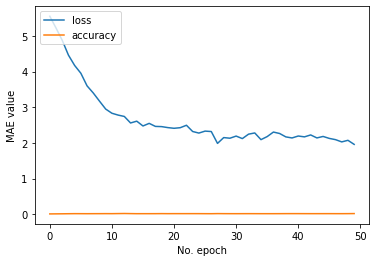

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#### Save models and weigths on disk

In [11]:
sepconv_mod.save("/tmp/sepconvnn")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/sepconvnn/assets


#### Inference on one sample star

In [12]:
for row in df.take(1):
    print("Batch shape (%s %s)" % (row[0].shape, row[1].shape))
    # Select first row on the batch
    X_star_test = row[0][0].numpy()
    y_star_test = row[1][0].numpy()
    
y_hats = sepconv_mod.predict_classes(X_star_test.reshape(1, 406, 3))
print("\nInference: Y_hat=%s | Y_test=%s" % (y_hats, np.where(y_star_test[0]==1)[0]))

Batch shape ((150, 406, 3) (150, 1, 100))

Inference: Y_hat=[33] | Y_test=[32]
